In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter

% matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

In [165]:
regions = dict(
    
    lfp = [
        "ctx_lh_S_front_sup.nii.gz",
        "ctx_lh_G_precentral.nii.gz",
        "ctx_lh_G_front_middle.nii.gz",
        "ctx_lh_G_and_S_cingul-Ant.nii.gz"
    ],
    
    rfp = [
        "ctx_rh_G_front_sup.nii.gz",
        "ctx_rh_G_postcentral.nii.gz",
        "ctx_rh_G_front_middle.nii.gz",
        "ctx_rh_G_front_inf-Orbital.nii.gz",
        "ctx_rh_G_and_S_transv_frontopol.nii.gz",
        "ctx_rh_G_precentral.nii.gz",
        "ctx_rh_S_front_middle.nii.gz",
        "ctx_rh_G_and_S_cingul-Ant.nii.gz"
    ],
    
    lt = [
        "ctx_lh_S_temporal_inf.nii.gz",
        "ctx_lh_G_temp_sup-G_T_transv.nii.gz",
        "ctx_lh_G_temporal_middle.nii.gz",
        "ctx_lh_G_temp_sup-Plan_polar.nii.gz",
        "ctx_lh_G_temp_sup-Lateral.nii.gz",
        "ctx_lh_G_temporal_inf.nii.gz",
        "ctx_lh_G_temp_sup-Plan_tempo.nii.gz",
        "ctx_lh_S_temporal_sup.nii.gz"
    ],
    
    rt = [
        "ctx_rh_G_temp_sup-Lateral.nii.gz",
        "ctx_rh_S_temporal_transverse.nii.gz",
        "ctx_rh_G_temp_sup-Plan_polar.nii.gz",
        "ctx_rh_G_temporal_middle.nii.gz",
        "ctx_rh_S_temporal_sup.nii.gz",
        "ctx_rh_G_temp_sup-Plan_tempo.nii.gz",
        "ctx_rh_G_temporal_inf.nii.gz",
        "ctx_rh_S_temporal_inf.nii.gz",
        "ctx_rh_G_temp_sup-G_T_transv.nii.gz"
    ],
    
    sc = [
        "Right-Thalamus-Proper.nii.gz",
        "Left-Thalamus-Proper.nii.gz",
        "Right-Accumbens-area.nii.gz",
        "Left-Accumbens-area.nii.gz",
        "Right-Caudate.nii.gz",
        "Left-Caudate.nii.gz",
        "Right-Putamen.nii.gz",
        "Left-Putamen.nii.gz",
        "Right-Amygdala.nii.gz",
        "Left-Amygdala.nii.gz",
        "Right-Hippocampus.nii.gz",
        "Left-Hippocampus.nii.gz"
    ]
    
)

In [166]:
means = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0)

In [157]:
ls

3dbrainviz.ipynb                      kids_vs_adults_rochists_featElim.png
RFCUSTOM.py                           oldk_vs_adult/
Untitled.ipynb                        oos_roc_rf.txt
all_td_age.csv                        regional.ipynb
alldata_rf_model.png                  resh5py
behav.txt                             results_with_nullmodel.h5py
feature_per_iteration_inclusions.csv  rf_featselect.ipynb
fszstatcope2_means_all.csv            rochist.png
fszstatcope2_means_nz.csv             sklearn_prelim.ipynb
fszstatcope2_means_nz_valset.csv      test_h5py
fszstatcope2_nvoxels_all.csv          valset_behav.csv
fszstatcope2_nvoxels_nz.csv           yk_ad_results_with_nullmodel.h5py
fszstatcope2_nvoxels_nz_valset.csv    yk_ok_results_with_nullmodel.h5py
git/                                  youngk_vs_adult/
glm.ipynb                             youngk_vs_oldk/
kids_vs_adults_alldata_rf_model.png


In [167]:
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == means.index)) #should be 1.0
behav2g = behav[np.logical_or(behav.young_kid == 1, behav.adult == 1)]
data2g = means[np.logical_or(behav.young_kid == 1, behav.adult == 1)]

1.0


In [168]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

In [161]:
def random_forest_model(data, y, cv, clf):
    X, P = data.values, data.shape[1]
    results = dict(pred=[], ytrue=[], fi=[], fidx=[])
    results_null = dict(pred=[], ytrue=[], fi=[], fidx=[])
    
    for idx, (train, test) in enumerate(cv.split(X, y)):   
        clf.fit(X[train], y[train])
        results["pred"].append(clf.predict(X[test]))
        results["ytrue"].append(y[test])
        results["fi"].append(clf.feature_importances_)
        results["fidx"].append([True for i in range(P)])
        
        # this is to compute the null model
        try:
            y_shuff = np.copy(y[train])
            np.random.shuffle(y_shuff)
            clf.fit(X[train], y_shuff)
            results_null["pred"].append(clf.predict(X[test]))
            results_null["ytrue"].append(y[test])
            results_null["fi"].append(clf.feature_importances_)
            results_null["fidx"].append([True for i in range(P)])
        except:
            print("couldn't compute null model")
        
    
    roc = roc_auc_score(np.array(results["ytrue"]).ravel(), np.array(results["pred"]).ravel())
    
    # this is to compute the null model
    try:
        roc_null = roc_auc_score(
            np.array(results_null["ytrue"]).ravel(),
            np.array(results_null["pred"]).ravel()
        )
    except:
        print("couldn't compute null roc score")
        
    return results, roc, results_null, roc_null

In [169]:
data2g = projection(data2g, behav2g.loc[:, ["gender", "iq", "composite_motion"]])

In [170]:
data_sets = {}

for key, group in regions.items():
    data_sets[key] = data2g.loc[:, group]
    

In [182]:
niters=100
rocs = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
rocs_null = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
res = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
res_null = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
 
for key, val in data_sets.items():
    for i_iter in np.arange(niters):
        cv=LeaveOneOut()
        clf=RandomForestClassifier(n_estimators=10)
        
        res_g, roc_g, resnull_g, rocnull_g = random_forest_model(
            val, 
            behav2g.young_kid.values,
            cv,
            clf
        )
        
        rocs[key].append(roc_g)
        rocs_null[key].append(rocnull_g)
        res[key].append(res_g)
        res_null[key].append(resnull_g)

# predictive roc scores

In [183]:
for key, val in rocs.items():
    print(key, "\t", np.mean(val))

lfp 	 0.6491272727272728
rfp 	 0.6015272727272728
lt 	 0.5552181818181817
rt 	 0.5549545454545455
sc 	 0.40193636363636365


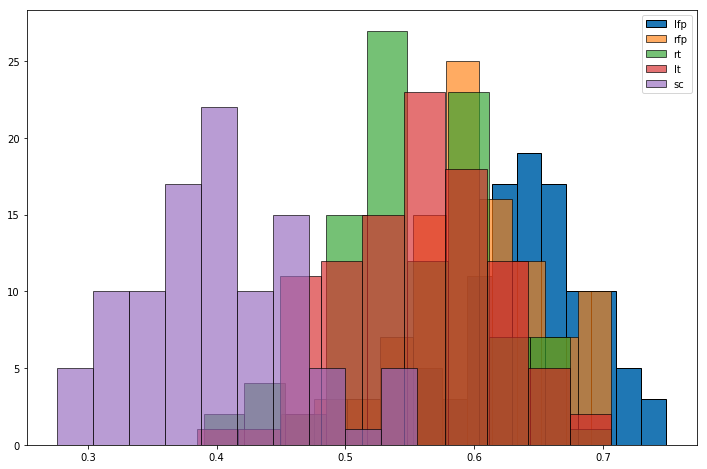

In [193]:
plt.figure(figsize=(12, 8))
plt.hist(rocs["lfp"], edgecolor="black")
plt.hist(rocs["rfp"], edgecolor="black", alpha=.65)
plt.hist(rocs["rt"], edgecolor="black", alpha=.65)
plt.hist(rocs["lt"], edgecolor="black", alpha=.65)
plt.hist(rocs["sc"], edgecolor="black", alpha=.65)
plt.legend(["lfp", "rfp", "rt", "lt", "sc"])

# empirical p-values

In [215]:
for key in ["lfp", "rfp", "lt", "rt", "sc"]:
    pval = (np.sum(rocs_null[key] >= np.mean(rocs[key])) + 1) / (niters + 1)
    print("region: {} p-value: {}".format(key, pval))

region: lfp p-value: 0.019801980198019802
region: rfp p-value: 0.039603960396039604
region: lt p-value: 0.12871287128712872
region: rt p-value: 0.19801980198019803
region: sc p-value: 0.8415841584158416


# feature importances

In [202]:
lfp_imps = np.zeros((niters, len(regions["lfp"])))
rfp_imps = np.zeros((niters, len(regions["rfp"])))
lt_imps = np.zeros((niters, len(regions["lt"])))
rt_imps = np.zeros((niters, len(regions["rt"])))
sc_imps = np.zeros((niters, len(regions["sc"])))

for i in np.arange(niters):
    lfp_imps[i, :] = np.array(res["lfp"][i]["fi"]).mean(0)
    rfp_imps[i, :] = np.array(res["rfp"][i]["fi"]).mean(0)
    lt_imps[i, :] = np.array(res["lt"][i]["fi"]).mean(0)
    rt_imps[i, :] = np.array(res["rt"][i]["fi"]).mean(0)
    sc_imps[i, :] = np.array(res["sc"][i]["fi"]).mean(0)

In [207]:
for pair in zip(regions["lfp"], lfp_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_lh_S_front_sup.nii.gz 	 0.23491725162854438
ctx_lh_G_precentral.nii.gz 	 0.2738833257972053
ctx_lh_G_front_middle.nii.gz 	 0.1883258237053612
ctx_lh_G_and_S_cingul-Ant.nii.gz 	 0.3028735988688893


In [208]:
for pair in zip(regions["rfp"], rfp_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_rh_G_front_sup.nii.gz 	 0.10031106639030694
ctx_rh_G_postcentral.nii.gz 	 0.20001410022832236
ctx_rh_G_front_middle.nii.gz 	 0.12148321118633748
ctx_rh_G_front_inf-Orbital.nii.gz 	 0.11352760694086808
ctx_rh_G_and_S_transv_frontopol.nii.gz 	 0.09253652175839067
ctx_rh_G_precentral.nii.gz 	 0.16652460636807795
ctx_rh_S_front_middle.nii.gz 	 0.09685940675178156
ctx_rh_G_and_S_cingul-Ant.nii.gz 	 0.10874348037591494


In [209]:
for pair in zip(regions["lt"], lt_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_lh_S_temporal_inf.nii.gz 	 0.1258579335431441
ctx_lh_G_temp_sup-G_T_transv.nii.gz 	 0.11485939038234902
ctx_lh_G_temporal_middle.nii.gz 	 0.13385354168310598
ctx_lh_G_temp_sup-Plan_polar.nii.gz 	 0.10153474459807231
ctx_lh_G_temp_sup-Lateral.nii.gz 	 0.11198580668851443
ctx_lh_G_temporal_inf.nii.gz 	 0.12645410319352945
ctx_lh_G_temp_sup-Plan_tempo.nii.gz 	 0.11570915360882843
ctx_lh_S_temporal_sup.nii.gz 	 0.1697453263024564


In [210]:
for pair in zip(regions["rt"], rt_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_rh_G_temp_sup-Lateral.nii.gz 	 0.10012266402172758
ctx_rh_S_temporal_transverse.nii.gz 	 0.09480240641667548
ctx_rh_G_temp_sup-Plan_polar.nii.gz 	 0.08281815557367292
ctx_rh_G_temporal_middle.nii.gz 	 0.1459234137218595
ctx_rh_S_temporal_sup.nii.gz 	 0.11442856825811205
ctx_rh_G_temp_sup-Plan_tempo.nii.gz 	 0.10093663702020252
ctx_rh_G_temporal_inf.nii.gz 	 0.1221560466648318
ctx_rh_S_temporal_inf.nii.gz 	 0.14237079092735114
ctx_rh_G_temp_sup-G_T_transv.nii.gz 	 0.09644131739556708


In [211]:
for pair in zip(regions["sc"], sc_imps.mean(0)):
    print(pair[0], "\t", pair[1])

Right-Thalamus-Proper.nii.gz 	 0.0786133698564401
Left-Thalamus-Proper.nii.gz 	 0.08952810687882938
Right-Accumbens-area.nii.gz 	 0.08117475441116227
Left-Accumbens-area.nii.gz 	 0.07212150895365896
Right-Caudate.nii.gz 	 0.06663621615364827
Left-Caudate.nii.gz 	 0.08047495157251641
Right-Putamen.nii.gz 	 0.0969690225780906
Left-Putamen.nii.gz 	 0.1022390964478393
Right-Amygdala.nii.gz 	 0.08841624017069635
Left-Amygdala.nii.gz 	 0.08031965723593118
Right-Hippocampus.nii.gz 	 0.0804377109175787
Left-Hippocampus.nii.gz 	 0.08306936482360854
